In [2]:
# load libraries
# ----------
import pandas as pd
import numpy as np
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

from tqdm import tqdm

import gensim
from gensim import models
from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.manifold import TSNE
import re

import multiprocessing

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
###' ################################################################################
###'
###' Load the data
###'
###'

df_14 = pd.read_csv("articles_data_14.csv")
df_24 = pd.read_csv("articles_data_24.csv")
    
df_14['Published'] = 0  # Code 0 for data from df_14
df_24['Published'] = 1  # Code 1 for data from df_24

df_14 = df_14[df_14['Abstract'] != 'Abstract not available.']
df_24 = df_24[df_24['Abstract'] != 'Abstract not available.']


df_14_S = df_14[['Title','Abstract','Published','Full Text']].dropna()
df_14_S['Abstract'] = df_14_S['Abstract'].apply(lambda x: re.sub(r'<\d+|\*|†>', '', re.sub(r'\<.*?\>', '', x)))

df_24_S = df_24[['Title','Abstract','Published','Full Text']].dropna()
df_24_S['Abstract'] = df_24_S['Abstract'].apply(lambda x: re.sub(r'<\d+|\*|†>', '', re.sub(r'\<.*?\>', '', x)))

df_a = pd.concat([df_14_S, df_24_S], ignore_index=True)


#df_S.head()
#len(df_S)

### define fuction
def rem_punc_stop(text):
    # When text is None
    if text is None:
        return []

    # Convert text to lowercase
    text = text.lower()

    # Define additional stop words
    stop_words = STOP_WORDS | {"abstract", "available", "student", "research", "study", "impact", "effect",
                               "result", "al", "et", "doi", "googlescholar", "google", "scholar", "textgoogle", 
                               "full", "crossref", "introduction", "background", "purpose" "aim", "objective","use","child"}
    # Define punctuation
    punc = set(punctuation)

    # Remove punctuation
    punc_free = "".join([ch for ch in text if ch not in punc])

    # Apply NLP processing
    doc = nlp(punc_free)

    # Tokenize and lemmatize
    text_lemma = " ".join([token.lemma_ for token in doc])

    # Filter tokens to remove URLs, stop words, and non-alphabetic tokens
    filtered_tokens = [word for word in text_lemma.split() if word not in stop_words and word.isalpha()]

    # Return filtered tokens for TfidfVectorizer
    return filtered_tokens
    

###' ################################################################################
###'
###' Apply the Function and Tokenize Text Column
###'
###'

### sample from the whole dataset
df_a['Title_tokens'] = df_a['Title'].map(lambda x: rem_punc_stop(x))
df_a['Abstract_tokens'] = df_a['Abstract'].map(lambda x: rem_punc_stop(x))
df_a['Full_tokens'] = df_a['Full Text'].map(lambda x: rem_punc_stop(x))


###' ################################################################################
###'
###' Filter Yet Published Papers
###'
###'

df_a['Full_count'] = df_a['Full Text'].dropna().apply(lambda x: len(str(x).split()))
df_S = df_a[df_a['Full_count'] >= 2000]


## Overview
In this lab, we will be turning individual words in the data set into vectors, called "Word Embeddings". Word embedding attempt to identify semantic relationships between words by observing them in the context that the word appears. Word2Vec is the most prominent word embedding algorithm.

Imagine that each word in a novel has its meaning determined by the ones that surround it in a limited window. For example, in Moby Dick's first sentence, “me” is paired on either side by “Call” and “Ishmael.” (“Call me Ishmael"). After observing the windows around every word in the novel (or many novels), the computer will notice a pattern in which “me” falls between similar pairs of words to “her,” “him,” or “them.” Of course, the computer had gone through a similar process over the words “Call” and “Ishmael,” for which “me” is reciprocally part of their contexts. This chaining of signifiers to one another mirrors some of humanists' most sophisticated interpretative frameworks of language.

The two main flavors of Word2Vec are CBOW (Continuous Bag of Words) and Skip-Gram, which can be distinguished partly by their input and output during training. Skip-Grams take a word of interest as its input (e.g., "me") and tries to learn how to predict its context words ("Call", "Ishmael"). CBOW does the opposite, taking the context words ("Call", "Ishmael") as a single input and tries to predict the word of interest ("me").

In general, CBOW is is faster and does well with frequent words, while Skip-Gram potentially represents rare words better.

## Model Training
Using pre-processed text, we can use the gensim library to construct our word embeddings. We will use the Continous Bag of Words model (CBOW), which predicts target words from its neighboring context words to learn word embeddings from raw text.

Read through the documentation of the Word2Vec method in gensim to understand how to implement the Word2Vec model. Then fill in the blanks so that: we use a Continuous Bag of Words model to create word embeddings of vector_size 100 for words that appear in the text at least 5 or more times. Set the learning rate to .025, epochs/number of iterations to 5, and sample 10000 words from the data during each pass.

In [4]:
model = gensim.models.Word2Vec(df_S['Abstract_tokens'],    # specify data - sentences
                               vector_size=100,   # set embedding size at 100
                               window=5,          # max distance between current and predicted word
                               min_count=5,       # ignores words with freq fewer than this threshold
                               sg=0,              # specify Continuous Bag of Words Algorithim
                               alpha=0.025,       # learning rate
                               epochs = 5,        # iterations
                               seed = 1,          # set random seed (same as random_state in sklearn )
                               batch_words=10000) # sample size

In [5]:
# return a list of word for which we have calculations
words = list(model.wv.index_to_key)
print(words[0:30])

['task', 'participant', 'performance', 'high', 'group', 'present', 'model', 'suggest', 'examine', 'visual', 'investigate', 'level', 'behavior', 'different', 'language', 'finding', 'test', 'social', 'experience', 'individual', 'control', 'cognitive', 'relationship', 'emotional', 'process', 'factor', 'emotion', 'time', 'response', 'influence']


In [6]:
# similarty between credit and debt
# ----------
model.wv.similarity('social', 'relationship')

0.99924874

In [7]:
# similarity between credit/debt and loan/mortgage
# ----------
model.wv.n_similarity(['aim','anxiety'],['emotional','behavior'])

0.99954545

In [8]:
# which doesn't belong?
# ----------
model.wv.doesnt_match(['approach', 'anxiety', 'emotional'])

'emotional'

In [9]:
# vector math
# ----------
model.wv.most_similar(positive=['experience', 'finding'], 
                      negative=['anxiety'])

[('strategy', 0.9992079138755798),
 ('enhance', 0.9991000890731812),
 ('similar', 0.9990915060043335),
 ('facilitate', 0.9990879893302917),
 ('space', 0.9990735650062561),
 ('location', 0.9990711212158203),
 ('human', 0.9990710616111755),
 ('observe', 0.99905925989151),
 ('stage', 0.9990537762641907),
 ('letter', 0.9990487098693848)]

## Principal Component Analysis
 Visualize the word embeddings of our text with PCA. We can retrieve all of the vectors from a trained model as follows.
 
 We can create a 2-dimensional PCA model of the word vectors using the scikit-learn PCA class. Construct a PCA objectusing the PCA() class of the scikit-learn library (setting n_components=2 so we can graph it in two dimensions) and use its fit_transform method on your standardized X to get Y_pca: the principal components.

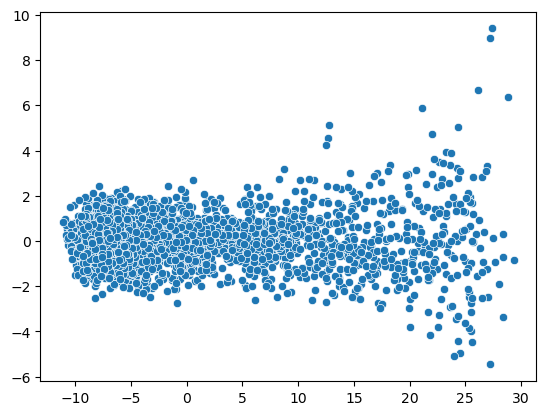

In [10]:
# retrieve vectors from trained model
# ----------
X = model.wv.__getitem__(model.wv.index_to_key)

# scale the data
# ----------
X_std = StandardScaler().fit_transform(X)

# make a PCA
# ----------
# set n_components to 2 to graph in 2-D
pca = PCA(n_components=2)  

# fit and transform the standardized data
# ----------
Y_pca = pca.fit_transform(X_std)

# visualize
# ----------
sns.scatterplot(x = Y_pca[:, 0],  # extract all the elements from the first column
                y = Y_pca[:, 1]); # extract all the elements from the second column

Each point represents a word. Because PCA selects and combines features according to what best describes and models the desired variable, the x and y axes actually don't have an intuitive meaning on a human level. PCA's job is to reduce the dimension of the features, and in this case it reduce the 100 features of each word vector to just the 2 that best described the words we modeled on. So, don't worry too much about what the coordinates of each word represents - we just want you to have a general and visual understanding of word vectors and how they may be related to one another on a graph.

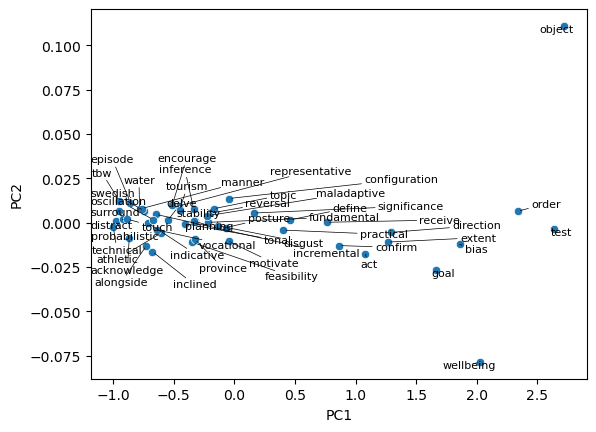

In [11]:
# recreate visualization with points
# ----------

# load libraires
import random
from adjustText import adjust_text

# set seeed
random.seed(10)

# take random sample words embeddings 
rando = random.sample(list(model.wv.index_to_key), 50) 

# get embeddings
X1 = model.wv.__getitem__(rando)

# initalize PCA
pca1 = PCA(n_components=2)

# fit and transform
result = pca1.fit_transform(X1)

# convert to dataframe 
result_df = pd.DataFrame(result,                   # specify data
                         columns = ['PC1', 'PC2'], # specify column names
                         index = rando)            # set index

# create scatterplot
sns.scatterplot(x = 'PC1',         # specify x-axis
                y = 'PC2',         # specify y-axis
                data = result_df)  # specify data

# initialize empty list
texts = []

# append words to list
for word in result_df.index:
    texts.append(plt.text(result_df.loc[word, 'PC1'], 
                          result_df.loc[word, 'PC2'], 
                          word, 
                          fontsize = 8))
    
# adjust plot text to prevent overlapping 
adjust_text(texts, 
            force_text = (0.4,0.4),
            expand = (1.2,1),
            arrowprops = dict(arrowstyle = "-", 
                              color = 'black', 
                              lw = 0.5))

# plot 
plt.show();

## t-SNE
Another popular unsupervised method for summarizing and visualizing word embeddings is t-distributed stochastic neighbor embedding.

Estimating the joint probability of the distance between each pair of points, assuming a Gaussian distribution.
Project the data into 1-dimension, and then estimate the joint probability of the distance between each pair of points assuming a Student's t-distribution.
Use gradient descent to update the second distribution to become similar to the first one.
The basic idea behind this two-step procedure is that we search for the the best lower dimensional representation that gets closest to modeling the original distances in higher dimensional space.

In [12]:
# preprocessing
# ----------

# filter to include only those for which Word2Vec has a vector
vector_list = [model.wv.__getitem__(word) for word in words if word in model.wv.index_to_key]

# create a list of the words corresponding to these vectors
words_filtered = [word for word in words if word in model.wv.index_to_key]

# bind together both lists using zip
word_vec_zip = zip(words_filtered, vector_list)

# create a dictionary and save as a dataframe
word_vec_dict = dict(word_vec_zip)
word_vec_df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
word_vec_df.shape

(2750, 100)

  File "D:\Program\ANACONDA\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


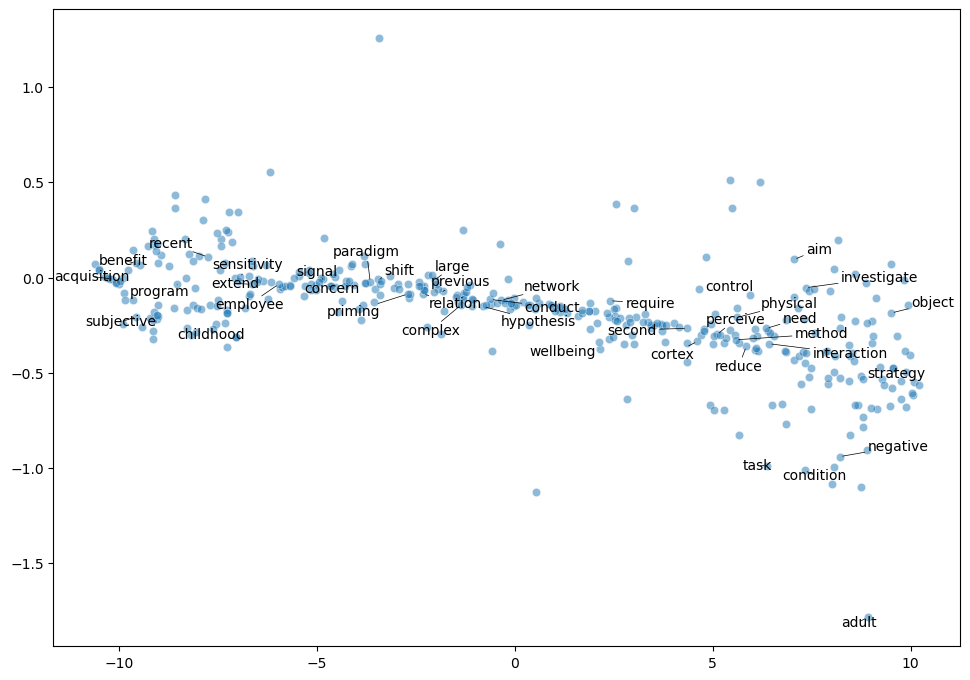

In [13]:
# create t-SNE visualization
# ----------

# initialize t-SNE
tsne = TSNE(n_components = 2,  # specify 2 components
            init = 'random',   # set initalization
            random_state = 10, # set seed
            perplexity = 100)  # set preplexity threshold

# subset to only 400 rows to speed up training time
tsne_df = tsne.fit_transform(word_vec_df[:400])

# figure specifications
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(x = tsne_df[:, 0], 
                y = tsne_df[:, 1], 
                alpha = 0.5)

# initialize empty list
texts = []

# create list of words
words_to_plot = list(np.arange(0, 400, 10))

# append words to list using loop
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], 
                          tsne_df[word, 1], 
                          word_vec_df.index[word], 
                          fontsize = 10))
    
# adjust text to clearlly see labels
adjust_text(texts, 
            force_text = (0.4,0.4),
            expand = (1.2,1),
            arrowprops = dict(arrowstyle = "-",
                              color = 'black', 
                              lw = 0.5))

# plot
plt.show()

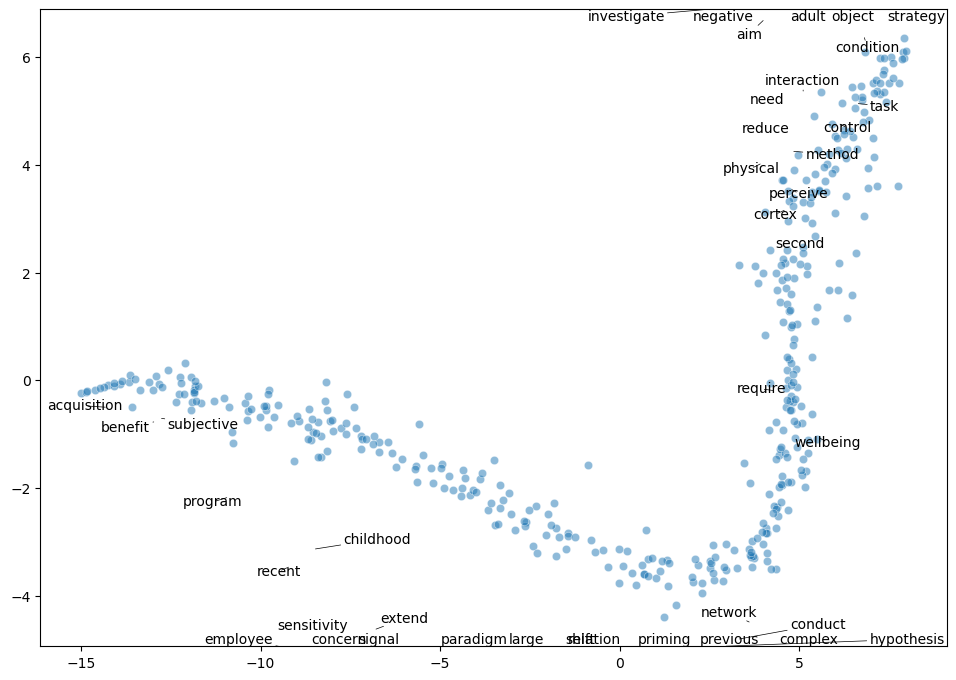

In [14]:
# recreate t-SNE visualization with 3 components
# ----------
tsne = TSNE(n_components = 3,  # specify 3 components  
            init = 'random',   # set initalization 
            random_state = 10, # set seed   
            perplexity = 40)   # set preplexity threshold
   

# subset to only 400 rows to speed up training time
tsne_df = tsne.fit_transform(word_vec_df[:400])



# figure specifications
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(x = tsne_df[:, 0], 
                y = tsne_df[:, 2], 
                alpha = 0.5)


# initialize empty list
texts = []

# create list of words
words_to_plot = list(np.arange(0, 400, 10))

# append words to list using loop
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], 
                          tsne_df[word, 1],
                          word_vec_df.index[word], 
                          fontsize = 10))
    
# adjust text to clearlly see labels   
adjust_text(texts, 
            force_text = (0.4,0.4),
            expand = (1.2,1),
            arrowprops = dict(arrowstyle = "-",
                              color = 'black', 
                              lw = 0.5))

# plot 
plt.show()

## Document averaged work embedding (doc2vec)
Document averaged word embeddings tend to perform well with downstream prediction tasks, but there are other options as well. Here, we'll take a look at Doc2Vec.

We're getting close to classifying, and this is a good point to do our train/test splits. While normally we recommend waiting to do splits until after all preprocessing is done, in this case it will be easier to do the split now because of the way the TaggedDocument class works. 

In [ ]:
# preprocessing
# ----------

# intitalize label binarizer
lb_style = LabelBinarizer()

# fit transform
y = df_S['Published_binary'] = lb_style.fit_transform(df_S["Published"])

# train/test split
train, test = train_test_split(df_S,             # specify dataset
                               test_size=0.2,    # specify test size
                               random_state=42)  # set seed
# view
train.head()

In [ ]:
# apply tag to each train/test dataset
# ----------

# tag training datatset
train_tagged = train.apply(lambda r: TaggedDocument(words=r['tokens'],
                                                         tags=[r.Product_binary]), 
                                axis=1)

# tag testing datatset
test_tagged = test.apply(lambda r: TaggedDocument(words=r['tokens'], 
                                                       tags=[r.Product_binary]),
                              axis=1)

# view the first row
train_tagged[0]

# count your cores for processing
# ----------
cores = multiprocessing.cpu_count()
cores



In [ ]:
# train a Doc2Vec model 
# ----------
# initalize Doc2Vec
model_dbow = Doc2Vec(dm=0,              # training algorithim: distributed bag of words
                     vector_size=300,   # word embedding size
                     negative=5,        # how many negative samples
                     hs=0,              # hierarchical softmax using negative samples
                     min_count=2,       # ignores all words with a total frequency lower than this threshold.
                     sample = 0,        # how much downsampling - 0 means none
                     workers=cores - 1) # how many cores will be used

# apply to training data
model_dbow.build_vocab([x for x in tqdm(cfpb_train_tagged.values)])

In [ ]:
# loop over our data
# ----------
for epoch in range(1,30):
    model_dbow.train(utils.shuffle([x for x in tqdm(cfpb_train_tagged.values)]), 
                     total_examples=len(cfpb_train_tagged.values), 
                     epochs=epoch)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [ ]:
# grab the embeddings
# ----------
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, regressors

In [ ]:
#
# Classifcation model
# ----------------------------------------


# intialize a logit model
# ----------

# split into training
y_train, X_train = vec_for_learning(model_dbow, # specify datasets for split
                                    cfpb_train_tagged)

# split into testing
y_test, X_test = vec_for_learning(model_dbow,  # specify datasets for split
                                  cfpb_test_tagged)

# initalize model
logit_reg = LogisticRegression() # intialize logit model

# fit on training
logit_model = logit_reg.fit(X_train,  # fit to training data
                            y_train)

# predict on test data
y_pred = logit_model.predict(X_test)  # predict on testing data


# confusion matrix
# ----------

# create confusion matrix 
cf_matrix = confusion_matrix(y_test,              # actual
                             y_pred,              # predictions
                             normalize = "true")  # normalize

# create dataframe
df_cm = pd.DataFrame(cf_matrix,   # specify matrix for calculations
                     range(2),
                     range(2))

# rename indices
df_cm = df_cm.rename(index=str, 
                     columns={0: "Mortgage", 1: "Student loan"})

df_cm.index = ["Mortgage", "Student loan"]

# plot specifications
# ----------
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Confusion Matrix')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()